<a href="https://colab.research.google.com/github/The-cheater/Deep_Learning_Models/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

# Unzip GAF Images
with zipfile.ZipFile('/content/drive/MyDrive/dataset/GAF_Images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/GAF_Images')

# Unzip MTF Images
with zipfile.ZipFile('/content/drive/MyDrive/dataset/MTF_Images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/MTF_Images')

# Check extracted folders
print("GAF Images:", os.listdir('/content/GAF_Images')[:5])
print("MTF Images:", os.listdir('/content/MTF_Images')[:5])


GAF Images: ['GAF_Images']
MTF Images: ['MTF_Images']


In [16]:
import os
import numpy as np
from PIL import Image

# Helper function to load images from nested folders
def load_images_and_labels(root_dir, img_size=(224, 224), color_mode='rgb'):
    images = []
    labels = []
    label_map = {'EL': 0, 'PD': 1, 'S': 2}

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for subject_folder in os.listdir(class_path):
                subject_path = os.path.join(class_path, subject_folder)
                if os.path.isdir(subject_path):
                    for img_name in os.listdir(subject_path):
                        img_path = os.path.join(subject_path, img_name)
                        if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                            img = Image.open(img_path)
                            img = img.convert('RGB')  # Always RGB
                            img = img.resize(img_size)
                            img_array = np.array(img) / 255.0
                            images.append(img_array)
                            labels.append(label_map[class_name])
    return np.array(images), np.array(labels)

# Load GAF images (RGB)
gaf_images, gaf_labels = load_images_and_labels('/content/GAF_Images/GAF_Images', color_mode='rgb')
print("✅ Loaded GAF images:", gaf_images.shape)

# Load MTF images (also RGB - viridis colormap)
mtf_images, mtf_labels = load_images_and_labels('/content/MTF_Images/MTF_Images', color_mode='rgb')
print("✅ Loaded MTF images:", mtf_images.shape)

# Ensure labels match
assert np.array_equal(gaf_labels, mtf_labels), "Labels do not match!"
labels = gaf_labels


✅ Loaded GAF images: (1025, 224, 224, 3)
✅ Loaded MTF images: (1025, 224, 224, 3)


In [17]:
import tensorflow as tf

batch_size = 16

# Create tf.data.Dataset for full training
full_ds = tf.data.Dataset.from_tensor_slices(((gaf_images, mtf_images), gaf_labels))
full_ds = full_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("✅ Full dataset ready.")


✅ Full dataset ready.


In [18]:
from tensorflow.keras import layers, Model, Input

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    return x

# Inputs
input_gaf = Input(shape=(224, 224, 3), name='gaf_input')
input_mtf = Input(shape=(224, 224, 3), name='mtf_input')

# GAF stream (4 blocks)
x1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_gaf)
x1 = conv_block(x1, 128)
x1 = conv_block(x1, 256)
x1 = conv_block(x1, 512)

# MTF stream (4 blocks)
x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_mtf)
x2 = conv_block(x2, 128)
x2 = conv_block(x2, 256)
x2 = conv_block(x2, 512)

# Merge
merged = layers.Concatenate(axis=-1)([x1, x2])

# Additional CNN blocks (matching diagram)
x = layers.Conv2D(512, 3, padding='same', activation='relu')(merged)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Fully connected layers (matching diagram)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=[input_gaf, input_mtf], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gaf_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mtf_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 224, 224,  │      1,792 │ gaf_input[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 224, 224,  │      1,792 │ mtf_input[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 224, 224,  │     73,856 │ conv2d_20[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 224, 224,  │     73,856 │ conv2d_24[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        512 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 112, 112,  │    295,168 │ max_pooling2d_16… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 112, 112,  │    295,168 │ max_pooling2d_19… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │  1,180,160 │ max_pooling2d_17

 Total params: 129,750,275 (494.96 MB)

 Trainable params: 129,744,643 (494.94 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [19]:
history = model.fit(
    full_ds,
    epochs=30
)


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 570ms/step - accuracy: 0.4478 - loss: 54.6548
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 487ms/step - accuracy: 0.4573 - loss: 9.5315
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 486ms/step - accuracy: 0.5363 - loss: 2.3653
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - accuracy: 0.5332 - loss: 1.9477
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 486ms/step - accuracy: 0.5382 - loss: 1.3996
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 486ms/step - accuracy: 0.6257 - loss: 1.0805
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 489ms/step - accuracy: 0.6340 - loss: 1.1674
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 486ms/step - accuracy: 0.6363 - loss: 1.0183
Epoch 9/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - accuracy: 0.6255 - loss: 0.9318
Epoch 10/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 0.6562 - loss: 1.0399
Epoch 11/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 489ms/step - accuracy: 0.6576 - loss: 0.8766
Epoch 12/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3

✅ Model saved to /content/mmcnn_model.h5


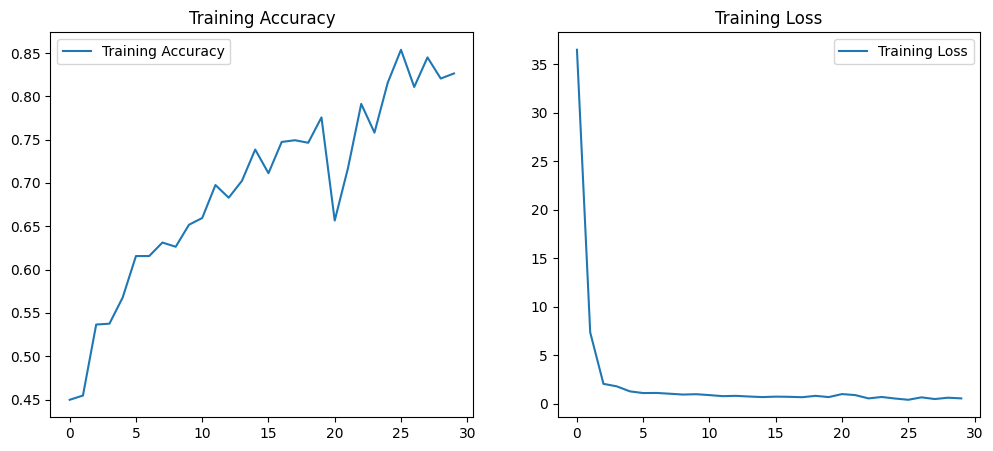

In [20]:
model.save('/content/mmcnn_model.h5')
print("✅ Model saved to /content/mmcnn_model.h5")
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.title('Training Loss')

plt.show()


In [14]:
# 📌 Upload GAF image
from google.colab import files
print("Please upload the GAF image (RGB)")
uploaded = files.upload()

# Get the filename
uploaded_filename_gaf = list(uploaded.keys())[0]
print("✅ Uploaded GAF file:", uploaded_filename_gaf)

# 📌 Upload MTF image
print("Please upload the MTF image (Viridis RGB)")
uploaded = files.upload()
uploaded_filename_mtf = list(uploaded.keys())[0]
print("✅ Uploaded MTF file:", uploaded_filename_mtf)

# 🖼️ Preprocessing function (both images are RGB)
from PIL import Image
import numpy as np

def preprocess_image(img_path, img_size=(224, 224)):
    img = Image.open(img_path).convert('RGB')  # always RGB
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Preprocess images
gaf_test = preprocess_image(uploaded_filename_gaf)
print("✅ GAF image shape:", gaf_test.shape)

mtf_test = preprocess_image(uploaded_filename_mtf)
print("✅ MTF image shape:", mtf_test.shape)

# ✅ Load the trained model
from tensorflow.keras.models import load_model

model = load_model('/content/mmcnn_model.h5')
print("✅ Model loaded successfully.")

# 🔮 Predict
predictions = model.predict([gaf_test, mtf_test])
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

# Class mapping
class_map = {0: 'EL', 1: 'PD', 2: 'S'}
print(f"✅ Predicted class: {class_map[predicted_class]}")
print(f"✅ Confidence: {confidence:.4f}")


Please upload the GAF image (RGB)


Saving s010_1high1_win2_gaf.png to s010_1high1_win2_gaf.png
✅ Uploaded GAF file: s010_1high1_win2_gaf.png
Please upload the MTF image (Viridis RGB)


Saving s010_1high1_win2_mtf.png to s010_1high1_win2_mtf.png
✅ Uploaded MTF file: s010_1high1_win2_mtf.png
✅ GAF image shape: (1, 224, 224, 3)
✅ MTF image shape: (1, 224, 224, 3)


✅ Model loaded successfully.


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d_4" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (1, 224, 224, 3)[0m

Arguments received by Functional.call():
  • inputs=('tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)')
  • training=False
  • mask=('None', 'None')